# Reconstruction sampling

The concept behind reconstruction sampling is simple:
- we know that a probability distribution can be represented with only a handful of points via Gaussian process regression (GPR)
- we don't know a-priori the true mean and covariance of the parameters in the model
- we can iteratively guess both by repeatedly evaluating the posterior at specific points, performing reconstruction, and sampling the reconstructed posterior via MCMC

In lieu of actually writing a piece of software, this notebook is for attemping to implement this algorithm on a simple distribution and doing each iteration in different cells, rather than in a function call.

In [1]:
import numpy as np
import emcee
import pyDOE2
import matplotlib.pyplot as plt
import ARTsampler as ARTsampler
%matplotlib inline

In [2]:
#Plot configurations
plt.rc("text", usetex=True)
plt.rc("font", size=24, family="serif")

## Step 0: define a true distribution

We will start with a simple example - a 2D Gaussian distribution.

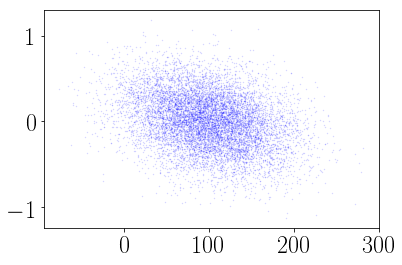

In [3]:
#True mean and covariance
true_means = np.array([100.0, 0.0])
stddevs = np.array([50.0, 0.1]) #standard deviations
rho = -0.99 #correlation
true_cov = np.array([[stddevs[0]**2, rho*stddevs[0]*stddevs[1]],
                    [rho*stddevs[0]*stddevs[1], stddevs[1]]])
true_samples = np.random.multivariate_normal(mean=true_means, cov=true_cov, size=10000).T
args = {"true_mean": true_means, "true_covariance": true_cov}
plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

## Step 0.5: define the log-likelihood

Our target distribution needs a log-likelihood. We will assume a flat prior so that the posterior is just the likelihood. In this really silly example, the likelihood knows the true mean and covariance, but in a real analysis there would be some kind of model involved.

In [4]:
def true_log_likelihood(params, args):
    #Params is a 2D array containing the two parameters (labeled x and y in figures)
    mu = args["true_mean"]
    C = args["true_covariance"]
    D = mu - params
    return -0.5 * np.dot(D, np.linalg.solve(C, D))

## Step 1: guess a mean and covariance

The first step for the reconstruction sampler is to guess a mean and covariance. We will then generate training samples using this guess, and compute the log-posterior probability of each of these samples.

In [5]:
#Our guess for the mean and covariance
guess_mean = np.array([20.0, 0.5]) #Note: parameter y is 5sigma away from the true mean
guess_cov = np.array([[30.**2, 0],[0, 0.08**2]])

Text(0, 0.5, '$y$')

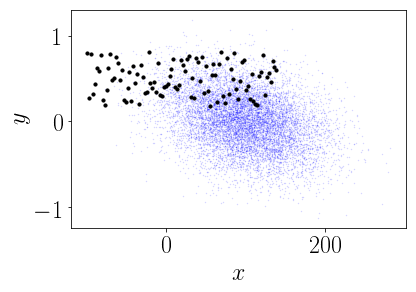

In [6]:
#Make a method for subsampling the Gaussian chain with a LH method.
def make_training_points(guess_mean, guess_cov, Nsamples=100):
    #Create LH training samples
    x = pyDOE2.lhs(len(guess_mean), samples=Nsamples,
                   criterion="center", iterations=5)
        
    #Transform them correctly
    x -= 0.5 #center the training points
    s = 8 #scale
    w, RT = np.linalg.eig(guess_cov)
    R = RT.T

    return np.dot(s*x[:]*np.sqrt(w), R.T)[:] + guess_mean

training_points = make_training_points(guess_mean, guess_cov)
plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [7]:
lnlikes = np.array([true_log_likelihood(p, args) for p in training_points])

# Step 2: construct and ARTsampler

Here we construct and ARTsampler object. The final version of this sampler will just take a log-posterior function and a guess for the mean and covariance, but for now it will take in the points we have computed so far.

In [8]:
art = ARTsampler.ARTstage(guess_mean, guess_cov, training_points, lnlikes)

# Step 3: Perform MCMC on the reconstructed posterior

We want to make an update to our `guess_mean` and `guess_cov`, which we can do by running an MCMC on the reconstructed posterior.

In [9]:
#Run a test where we draw from the predicted likelihood surface
initial = guess_mean
ndim, nwalkers = len(initial), 16
sampler = emcee.EnsembleSampler(nwalkers, ndim, art.predict)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 100)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 100)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 2000)
testchain = sampler.flatchain;

Running first burn-in
Running second burn-in
Running production...


Text(0, 0.5, '$y$')

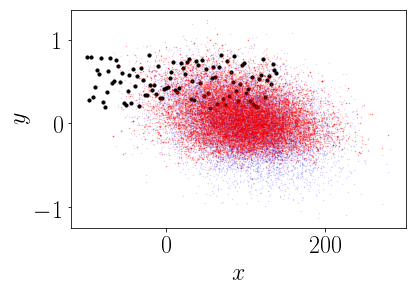

In [10]:
plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10)
plt.scatter(testchain[:,0], testchain[:,1], marker='.', c='r', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

## Step 3: repeat until convergence

Wooooo looking good! We can see that even though the training points (black) only partially cover the high-probability region, the reconstructed probability does a reasonable job at updating things. From here we can make a new `guess_mean` and `guess_cov` and repeat the process.

In [11]:
guess_mean = np.mean(testchain, 0)
guess_cov = np.cov(testchain.T)
training_points = make_training_points(guess_mean, guess_cov)

In [12]:
lnlikes = np.array([true_log_likelihood(p, args) for p in training_points])
art = ARTsampler.ARTstage(guess_mean, guess_cov, training_points, lnlikes)

initial = guess_mean
ndim, nwalkers = len(initial), 16
sampler = emcee.EnsembleSampler(nwalkers, ndim, art.predict)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 100)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 100)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 2000)
testchain = sampler.flatchain;

Running first burn-in
Running second burn-in
Running production...


Text(0, 0.5, '$y$')

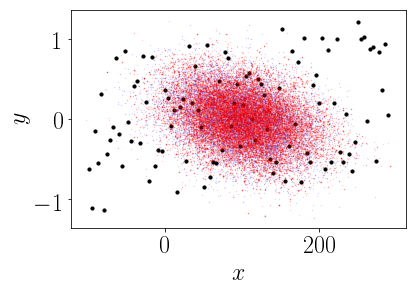

In [13]:
plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10)
plt.scatter(testchain[:,0], testchain[:,1], marker='.', c='r', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [14]:
print("True means:  ", true_means)
print("2iter means: ", np.mean(testchain, 0))

True means:   [100.   0.]
2iter means:  [1.00851844e+02 2.11249876e-03]


In [15]:
print("True cov:  \n", true_cov)
print("2iter cov: \n", np.cov(testchain.T))

True cov:  
 [[ 2.50e+03 -4.95e+00]
 [-4.95e+00  1.00e-01]]
2iter cov: 
 [[ 2.40956815e+03 -4.59865765e+00]
 [-4.59865765e+00  1.00201517e-01]]


## Great success!

We see that only after two iteration we achieve what we want. A 1% estimate of the means of our parameters and good estimate of the covariance.